In [1]:
import tensorflow as tf
import glob
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
#from data_handler import *
import time
import scipy
from scipy.misc import imread
import pylab as plt
import matplotlib as mpl
from scipy import stats


/home/pranjal/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
FILEPATH = '/home/pranjal/FUTURE_dataset/data64/'
#FILEPATH = '/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/FUTURE/data64/'

In [147]:
images_list = {}
si = 1
ei = si+6000

for i in range(si, ei):
    name = str(i).zfill(4)
    foldername = 'sim'+name
    files = glob.glob(FILEPATH+foldername+'/scattering/*.npy')
    images_list[name] = []
    files.sort()
        
    for f in files:
        img = np.load(f)
        values = np.sort( img.flatten() )
        vmin   = values[ +int( len(values)*0.01 ) ]
        idx    = -int( len(values)*0.01 )
        if idx >=0:
            idx = -1
        vmax = values[idx]
        img[img > vmax] = vmax
        img[img < vmin] = vmin
        img = (img-vmin)/(vmax-vmin)
        images_list[name].append(img)
        #images_list[name].append(imread(f))

In [148]:
current = []
future  = []
names   = []

for k in images_list:
    if len(images_list[k]) >= 40:
        a = np.array(images_list[k][0:10])
        b = np.array(images_list[k][10:20])
        if len(a.shape) == 3 and len(b.shape) == 3:
            current.append(a)
            future.append(b)
        a = np.array(images_list[k][20:30])
        b = np.array(images_list[k][30:40])
        if len(a.shape) == 3 and len(b.shape) == 3:
            current.append(a)
            future.append(b)
    elif len(images_list[k]) >= 20:
        a = np.array(images_list[k][0:10])
        b = np.array(images_list[k][10:20])
        if len(a.shape) == 3 and len(b.shape) == 3:
            current.append(a)
            future.append(b)

current = np.array(current)
future  = np.array(future)

print(current.shape)
print(future.shape)

# x_test = current
# y_test = future

x_train = current
y_train = future

(8161, 10, 64, 64)
(8161, 10, 64, 64)


temp length is  1000


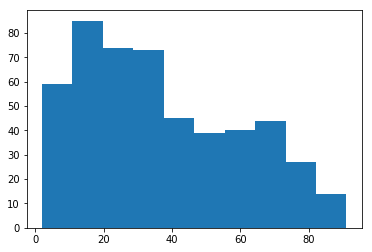

Mode is  ModeResult(mode=array([32]), count=array([20]))
2 0
91
1
2
2
4
0


In [89]:
#temp = x_train[0][0].flatten()
# temp = np.load('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/FUTURE/data64/sim1027/scattering/frame0013.npy')
# temp = temp.flatten()
# temp = np.sort(temp)

#temp = temp[3200:]
temp  = max_a
print('temp length is ', len(temp))
temp = np.sort(temp)
temp = temp[:int(len(temp)*0.5)]
plt.hist(temp, bins=10)
plt.show()

print('Mode is ', stats.mode(temp))
print(np.min(temp), list(temp).count(0))
print(np.max(temp))
print(list(temp).count(np.max(temp)))
print(list(temp).count(np.max(temp)-1))
print(list(temp).count(np.max(temp)-2))
print(list(temp).count(np.max(temp)-3))
print(list(temp).count(0))

In [149]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8161, 10, 64, 64)
(8161, 10, 64, 64)
(1750, 10, 64, 64)
(1750, 10, 64, 64)


In [150]:
x_train_flat = x_train.reshape(x_train.shape[0], 10, 4096)
y_train_flat = y_train.reshape(x_train.shape[0], 10, 4096)
x_test_flat = x_test.reshape(x_test.shape[0], 10, 4096)
y_test_flat = y_test.reshape(x_test.shape[0], 10, 4096)

print(x_train_flat.shape)
print(y_train_flat.shape)
print(x_test_flat.shape)
print(y_test_flat.shape)

(8161, 10, 4096)
(8161, 10, 4096)
(1750, 10, 4096)
(1750, 10, 4096)


In [69]:
batch_size = 80     # Batch size for training.
epochs     = 10     # Number of epochs to train for.
latent_dim = 2048   # Latent dimensionality of the encoding space.
num_samples = 500   # Number of samples to train on.

max_encoder_seq_length = 10
max_decoder_seq_length = 10
num_encoder_tokens = 4096
num_decoder_tokens = 4096
input_texts = 1
temp_zero   = np.zeros(4096)

In [151]:
encoder_input_data  = x_train_flat
decoder_target_data = y_train_flat
y_train_flat_copy   = y_train_flat.copy()

for i in range(len(y_train_flat_copy)):
    y_train_flat_copy[i] = np.roll(y_train_flat_copy[i], 1, axis=0)
    y_train_flat_copy[i][0] = temp_zero

decoder_input_data = y_train_flat_copy

print(encoder_input_data.shape)
print(decoder_target_data.shape)
print(decoder_input_data.shape)

(8161, 10, 4096)
(8161, 10, 4096)
(8161, 10, 4096)


In [99]:
def my_loss(y_true, y_pred):
    mask_true = K.cast(K.not_equal(y_true, y_pred), K.floatx())
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    num = K.sum(masked_squared_error, axis=-1)
    den = K.sum(mask_true, axis=-1)
    masked_mse =  num/den 
    masked_mse = masked_mse*100
    #print(K.eval(den))
    return masked_mse
    
#     all_zero = y_true+y_pred
#     non_z = K.count_nonzero(all_zero)
#     print(K.int_shape(non_z), K.shape(y_true), K.shape(y_pred))
# #     for i, k in enumerate(all_zero):
# #         tp = np.count_nonzero(all_zero[i])
# #         t.append(tp)
#     new_result = K.square(y_pred-y_true)
#     for i, k in new_result:
#         new_result[i] = new_result[i]/t[i]
#     return K.mean(K.square(new_result), axis=-1)
    

# def dice_coef(y_true, y_pred, smooth, thresh):
#     y_pred = y_pred > thresh
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)

#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [102]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
print(encoder_outputs.shape, state_h.shape, state_c.shape)
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
print(decoder_outputs.shape)
decoder_dense = Dense(num_decoder_tokens, activation='relu')
decoder_outputs = decoder_dense(decoder_outputs)
print(decoder_outputs.shape)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='adam', loss=my_loss)

(?, 2048) (?, 2048) (?, 2048)
(?, ?, 2048)
(?, ?, 4096)


In [103]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_33 (InputLayer)            (None, None, 4096)    0                                            
____________________________________________________________________________________________________
input_34 (InputLayer)            (None, None, 4096)    0                                            
____________________________________________________________________________________________________
lstm_27 (LSTM)                   [(None, 2048), (None, 50339840    input_33[0][0]                   
____________________________________________________________________________________________________
lstm_28 (LSTM)                   [(None, None, 2048),  50339840    input_34[0][0]                   
                                                                   lstm_27[0][1]           

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=10, epochs=60)

# Save model
#model.save('s2s.h5')

Epoch 1/60
8161/8161 [==============================] - 122s - loss: 0.8060   
Epoch 2/60
8161/8161 [==============================] - 107s - loss: 0.8071   
Epoch 3/60
8161/8161 [==============================] - 116s - loss: 0.8044   
Epoch 4/60
8161/8161 [==============================] - 94s - loss: 0.8053    
Epoch 5/60
8161/8161 [==============================] - 94s - loss: 0.8011    
Epoch 6/60
8161/8161 [==============================] - 95s - loss: 0.7987    
Epoch 7/60
8161/8161 [==============================] - 95s - loss: 0.7972    
Epoch 8/60
8161/8161 [==============================] - 105s - loss: 0.7985   
Epoch 9/60
8161/8161 [==============================] - 95s - loss: 0.7975    
Epoch 10/60
8161/8161 [==============================] - 95s - loss: 0.8010    
Epoch 11/60
8161/8161 [==============================] - 95s - loss: 0.7927    
Epoch 12/60
8161/8161 [==============================] - 95s - loss: 0.7879    
Epoch 13/60
8161/8161 [==========================

In [163]:
model.save('future_60_epochs.h5')

In [165]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [154]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    decoded_sentence = []
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for idk in range(0, 10):
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        decoded_sentence.append(output_tokens)
        target_seq = output_tokens
        # Update states
        states_value = [h, c]
    return decoded_sentence

# for seq_index in range(100):
#     # Take one sequence (part of the training test)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index: seq_index + 1]
    
#     start = time.time()
#     decoded_sentence = decode_sequence(input_seq)
#     timespent  = time.time() - start
#     print('TIME SPENT IS ', timespent)

In [48]:
print(encoder_input_data.shape)

(698, 10, 4096)


In [142]:
tp = try_output_data[0][0].reshape((64, 64))
print(tp, np.max(tp))

[[0.         0.         0.01694915 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.01694915 0.         ... 0.         0.         0.        ]] 1.0


In [143]:
tp = decoded_sentence[0][0].reshape((64, 64))
print(tp, np.max(tp))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 1.070703


In [168]:
image_index = 80
try_input_data  = encoder_input_data[image_index, 0:10, :]
try_output_data = decoder_target_data[image_index, 0:10, :]

try_output_data = np.expand_dims(try_output_data, axis=0)
try_input_data  = np.expand_dims(try_input_data, axis=0)
print(try_input_data.shape)
print(try_output_data.shape)


input_seq = try_input_data#encoder_input_data[seq_index: seq_index + 1]
decoded_sentence = decode_sequence(try_input_data)
decoded_sentence = np.array(decoded_sentence)
print('decoded_sentence shape ', decoded_sentence.shape)
#print(decoded_sentence[0], len(decoded_sentence))
# endtime = time.time()
# timespent  = endtime - start
# print(start, endtime)
# print (time.localtime( start ))
# print (time.localtime( endtime ))
# print(timespent)


for i in range(decoded_sentence.shape[0]):
    img  = decoded_sentence[i][0][0]
    fig = plt.figure(frameon=False)
    fig.set_size_inches(0.64,0.64)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
#     values = np.sort( img )
#     vmin = values[ +int( len(values)*0.01 ) ]
#     idx = -int( len(values)*0.01 )
#     if idx>=0:
#         idx = -1
#     vmax = values[idx]
    img = img.reshape(64, 64)
    vmin = np.min(img)
    vmax = np.max(img)
    #print(vmin, vmax, img.shape)
    ax.imshow(img, vmin=0, vmax=1, cmap=mpl.cm.jet)
    outfile = '/home/pranjal/finalresult/'+str(image_index)+'_'+str(i)+'.png'
    time.sleep(0.5)
    fig.savefig(outfile)
    
    img  = try_output_data[0][i]
    #img = img.reshape(64, 64)
    fig = plt.figure(frameon=False)
    fig.set_size_inches(0.64,0.64)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
#     values = np.sort( img )
#     vmin = values[ +int( len(values)*0.01 ) ]
#     idx = -int( len(values)*0.01 )
#     if idx>=0:
#         idx = -1
#     vmax = values[idx]
    img = img.reshape(64, 64)
    vmin = np.min(img)
    vmax = np.max(img)
    ax.imshow(img, vmin=0, vmax=1, cmap=mpl.cm.jet)
    outfile = '/home/pranjal/finalresult/real_'+str(image_index)+'_'+str(i)+'.png'
    time.sleep(0.5)
    fig.savefig(outfile)

(1, 10, 4096)
(1, 10, 4096)
decoded_sentence shape  (10, 1, 1, 4096)


/home/pranjal/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [ ]:
# For testing the loss function
y_pred = K.constant([[ 1, 1, 1, 1], 
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3]])
y_true = K.constant([[ 1, 1, 1, 1],
                     [ 1, 1, 1, 1],
                     [-1, 1, 1, 1],
                     [-1,-1, 1, 1],
                     [-1,-1,-1, 1],
                     [-1,-1,-1,-1]])

true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(my_loss(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], sep='\t')

In [ ]:
temp  = []
max_a = []
min_a = []

for k in images_list:
    temp = images_list[k]
    image_index = 0
    tmp  = np.array(temp)
    vmin = np.min(tmp)
    vmax = np.max(tmp)
    for img in temp:
        fig = plt.figure(frameon=False)
        fig.set_size_inches(0.64,0.64)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap=mpl.cm.jet)
        outfile = '/home/pranjal/testimages_real2/'+str(image_index)+'_'+str(i)+'_test1.png'
        fig.savefig(outfile)
        image_index = image_index+1
    
    #temp = np.array(temp)
    #max_a.append(np.max(temp))
    #min_a.append(np.min(temp))

#min_a = np.array(min_a)
#max_a = np.array(max_a)